In [95]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import copy

def find_closest_values(s, x):
    idx = (np.abs(s - x)).argmin()
    return idx
    
def crop_df_time(df, start_time, end_time):
    
    start_index = find_closest_values(df['Time'], start_time)
    end_index = find_closest_values(df['Time'], end_time)
    new_df = df[start_index:end_index]
    new_df = new_df.reset_index()
    return new_df

def upsample_dataframes(df1, df2):
    # Check which dataframe has fewer measurements
    if len(df1) < len(df2):
        shorter_df, longer_df = df1, df2
    else:
        shorter_df, longer_df = df2, df1

    # Calculate the ratio for upsampling
    ratio = len(longer_df) // len(shorter_df)

    # Upsample the shorter dataframe to match the length of the longer dataframe
    upsampled_shorter_df = pd.concat([shorter_df] * ratio, ignore_index=True)

    # Trim the longer dataframe to match the length of the shorter dataframe
    trimmed_longer_df = longer_df.iloc[:len(upsampled_shorter_df)]

    return trimmed_longer_df, upsampled_shorter_df

def scale_time(df): 
    
    df_ = copy.deepcopy(df)
    df_['Time'] = df['Time'] - df['Time'][0]
    return df_

def plot_position(pandas_odometry): 
    t = pandas_odometry['Time']
    x = pandas_odometry['pose.pose.position.x']
    y = pandas_odometry['pose.pose.position.y']
    z = pandas_odometry['pose.pose.position.z']
    
    plt.figure(figsize=(14, 5))

    # Plot positions over time
    plt.plot(t, x, label='X Position', color='red')
    plt.plot(t, y, label='Y Position', color='green')
    plt.plot(t, z, label='Z Position', color='blue')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position[m]')
    plt.title('Position')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def get_relative_position(odom1, odom2): 
    
    t1 = odom1['Time']; t2 = odom2['Time']
    len_t1 = len(t1); len_t2 = len(t2)
    
    if len(t1) > len(t2): 
        len_t1 = len(t2)
    else: 
        len_t2 = len(t1)
        
    print(len_t1)
    print(len_t2)
        
    x1 = odom1['pose.pose.position.x'][:len_t1]
    y1 = odom1['pose.pose.position.y'][:len_t1]
    z1 = odom1['pose.pose.position.z'][:len_t1]
    
    x2 = odom2['pose.pose.position.x'][:len_t2]
    y2 = odom2['pose.pose.position.y'][:len_t2]
    z2 = odom2['pose.pose.position.z'][:len_t2]
    t1 = t1[:len_t1]
    t2 = t2[:len_t2]
    
    t = t1
    x = x1-x2
    y = y1-y2
    z = z1-z2 
    
    return t,x,y,z

def extract_positions(odom1): 
    
    odom1 = scale_time(odom1)
    t = odom1['Time']
    x = odom1['pose.pose.position.x']
    y = odom1['pose.pose.position.y']
    z = odom1['pose.pose.position.z']
    return t, x, y, z

def extract_velocities(odom1):
    
    odom1 = scale_time(odom1)
    t = odom1['Time']
    vx = odom1['twist.twist.linear.x']
    vy = odom1['twist.twist.linear.y']
    vz = odom1['twist.twist.linear.z']
    return t, vx, vy, vz
    
def plot_relative_position(t, x, y, z): 
    
    plt.figure(figsize=(10, 6))

    # Plot positions over time
    plt.plot(t, x, label='X Position', linestyle='-')
    plt.plot(t, y, label='Y Position', linestyle='-')#, marker='s')
    plt.plot(t, z, label='Z Position', linestyle='-')#, marker='^')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position')
    plt.title('Positions Over Time')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def plot_trajectories(x1, y1, z1, x2, y2, z2, fig_w=15, fig_h=15):
    """
    Plots a trajectory in 3D space.

    Parameters:
    - x_coords (list): List of x-coordinates.
    - y_coords (list): List of y-coordinates.
    - z_coords (list): List of z-coordinates.

    Returns:
    - None
    """
    # Create a 3D figure
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory as a 3D line
    ax.plot(x1, y1, z1, label='UAV trajectory', linewidth=1, color='blue')
    ax.plot(x2, y2, z2, label='Net trajectory', linewidth=1, color='red', linestyle='--')

    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()    
    
    fig.savefig('3d_trajectory.svg')
    
def plot_positions(t1, x1, y1, z1, t2, x2, y2, z2, name="Position", title=None):
    """
    Plot positions of two objects over time in a subplot with two subplots (one below the other).

    Parameters:
    - object1_positions: List or NumPy array of positions for object 1 over time.
    - object2_positions: List or NumPy array of positions for object 2 over time.
    - time_values: List or NumPy array of time values.

    Returns:
    - None (displays the plot).
    """
    if len(t1) != len(t2):
        x1, x2 = upsample_dataframes(x1, x2)
        y1, y2 = upsample_dataframes(y1, y2)
        z1, z2 = upsample_dataframes(z1, z2)
        t1, t2 = upsample_dataframes(t1, t2)

    # Create a 2x1 subplot grid
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # Plot object 1 positions
    ax1.plot(t1, x1, label='x_uav', color='red')
    ax1.plot(t2, x2, label='x_net', color='red', linestyle='--')
    ax1.set_ylabel('x[m]')
    ax1.grid()
    ax1.legend()

    # Plot object 2 positions
    ax2.plot(t1, y1, label='y_uav', color='green')
    ax2.plot(t2, y2, label='y_net', color='green', linestyle='--')
    ax2.set_ylabel('y[m]')
    ax2.grid()
    ax2.legend()
    
    ax3.plot(t1, z1, label="z_uav", color='blue')
    ax3.plot(t2, z2, label='z_net', color='blue', linestyle='--')
    ax3.set_ylabel('z[m]')
    ax3.set_xlabel('t[s]')
    ax3.grid()
    ax3.legend()

    # Set a title for the entire subplot
    if title:
        plt.suptitle('Position [m], max_v = {}, max_a = {}'.format(title[0], title[1]))
    else: 
        plt.suptitle('Position [m]')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig('{}.svg'.format(name))
    
    
def plot_positions_full(t, x, y, z, name="Position", title=None):
    """
    Plot positions of two objects over time in a subplot with two subplots (one below the other).

    Parameters:
    - object1_positions: List or NumPy array of positions for object 1 over time.
    - object2_positions: List or NumPy array of positions for object 2 over time.
    - time_values: List or NumPy array of time values.

    Returns:
    - None (displays the plot).
    """
    last_t = 1
    for i, t_ in enumerate(t): 
        if len(t_) > last_t: 
            last_t = len(t_)
            max_i = i
            
    for x_, y_, z_ in zip(x_, y_, z_): 
        x_  = upsample_dataframes(x_, x[max_i])
        y_  = upsample_dataframes(y_, y[max_i])
        z_  = upsample_dataframes(z_, z[max_i])

    # Create a 2x1 subplot grid
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # Plot object 1 positions
    ax1.plot(t1, x1, label='x_uav', color='red')
    ax1.plot(t2, x2, label='x_net', color='red', linestyle='--')
    ax1.set_ylabel('x[m]')
    ax1.grid()
    ax1.legend()

    # Plot object 2 positions
    ax2.plot(t1, y1, label='y_uav', color='green')
    ax2.plot(t2, y2, label='y_net', color='green', linestyle='--')
    ax2.set_ylabel('y[m]')
    ax2.grid()
    ax2.legend()
    
    ax3.plot(t1, z1, label="z_uav", color='blue')
    ax3.plot(t2, z2, label='z_net', color='blue', linestyle='--')
    ax3.set_ylabel('z[m]')
    ax3.set_xlabel('t[s]')
    ax3.grid()
    ax3.legend()

    # Set a title for the entire subplot
    if title:
        plt.suptitle('Position [m], max_v = {}, max_a = {}'.format(title[0], title[1]))
    else: 
        plt.suptitle('Position [m]')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig('{}.svg'.format(name))
    
def find_topic_name_and_index(topic_name, csv_files): 
    for i, name in enumerate(csv_files): 
        if topic_name in name: 
            print("index: {}; topic_name: {}".format(i, name))
            
def find_bag_by_name(name, bag_list): 
    for i, bag_name in enumerate(bag_list): 
        if name in bag_name: 
            print("bag_name: {}".format(i))
            
def create_csv(bagreader_object):
    csv_files = []
    for topic in bagreader_object.topics:
        data = bagreader_object.message_by_topic(topic)
        csv_files.append(data)
    return csv_files
    
    

In [41]:
# First fly test 
bag_name = "./bags/first_fly_test.bag" 

bag_paths = []
for bag_name in os.listdir("./bags"):
    bag_paths.append("./bags/{}".format(bag_name))
    

find_bag_by_name('slow', bag_paths)
find_bag_by_name('middle', bag_paths)
find_bag_by_name('fast', bag_paths)

b_slow = bagreader(bag_paths[11])
b_middle = bagreader(bag_paths[17])
b_fast = bagreader(bag_paths[14])

bag_name: 11
bag_name: 14
bag_name: 19
bag_name: 20
bag_name: 15
bag_name: 17
[INFO]  Data folder ./bags/bezier_full_slow already exists. Not creating.


IsADirectoryError: [Errno 21] Is a directory: './bags/bezier_full_fast'

In [ ]:
csv_slow = create_csv(b_slow)
csv_middle = create_csv(b_middle)
csv_fast = create_csv(b_fast)

In [42]:
topic_name = "net"
find_topic_name_and_index(topic_name, csv_fast)

index: 4; topic_name: ./bags/bezier_full_fast/net-vrpn_client-estimated_odometry.csv
index: 5; topic_name: ./bags/bezier_full_fast/net-vrpn_client-estimated_transform.csv
index: 6; topic_name: ./bags/bezier_full_fast/net-vrpn_client-vicon_intermediate_results.csv


In [43]:
uav_slow_pose = pd.read_csv(csv_files[3]); uav_pose = scale_time(uav_pose)
net_slow_pose = pd.read_csv(csv_files[8]); net_pose = scale_time(net_pose)

NameError: name 'csv_files' is not defined

In [87]:
# Slow
uav_slow = pd.read_csv(csv_slow[1]); uav_slow = scale_time(uav_slow)
net_slow = pd.read_csv(csv_slow[4]); net_slow = scale_time(net_slow)

# Mid
uav_mid = pd.read_csv(csv_middle[1]); uav_mid = scale_time(uav_mid)
net_mid = pd.read_csv(csv_middle[4]); net_mid = scale_time(net_mid)

# Fast
uav_fast = pd.read_csv(csv_fast[1]); uav_fast = scale_time(uav_fast)
net_fast = pd.read_csv(csv_fast[4]); net_fast = scale_time(net_fast)

In [80]:
print(uav_slow)

      index        Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0     11123  119.985909       11123         1694438834           996183751   
1     11124  120.030120       11124         1694438835            43197328   
2     11125  120.030126       11125         1694438835            68256411   
3     11126  120.127690       11126         1694438835           169207577   
4     11127  120.164752       11127         1694438835           206312692   
...     ...         ...         ...                ...                 ...   
1200  12323  134.961968       12323         1694438849           985203829   
1201  12324  134.961973       12324         1694438849           992192381   
1202  12325  134.961981       12325         1694438849           993180604   
1203  12326  134.961989       12326         1694438849           996172052   
1204  12327  134.963564       12327         1694438850             5186298   

     header.frame_id child_frame_id  pose.pose.position.x  \
0 

## UAV and Net position

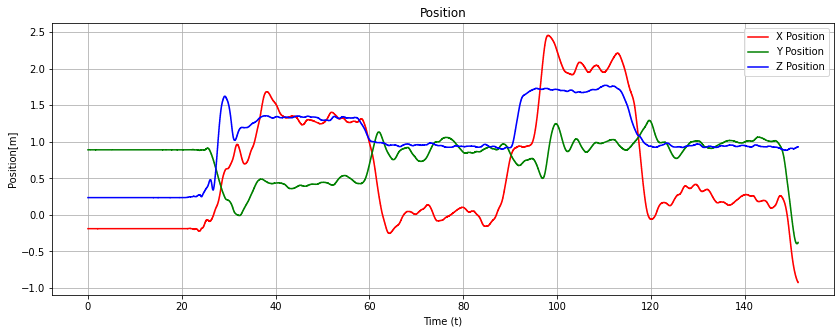

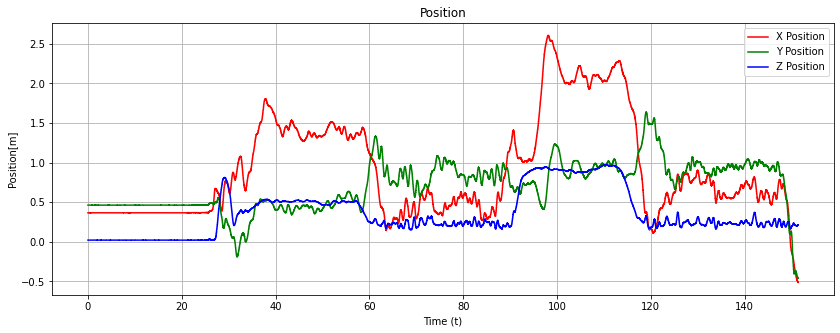

In [8]:
plot_position(uav_pose)
plot_position(net_pose)

In [18]:
t1,x1,y1,z1 = extract_positions(uav_pose)
t2,x2,y2,z2 = extract_positions(net_pose)
print(len(t1), len(t2))

35887 35686


## UAV and net position subplot

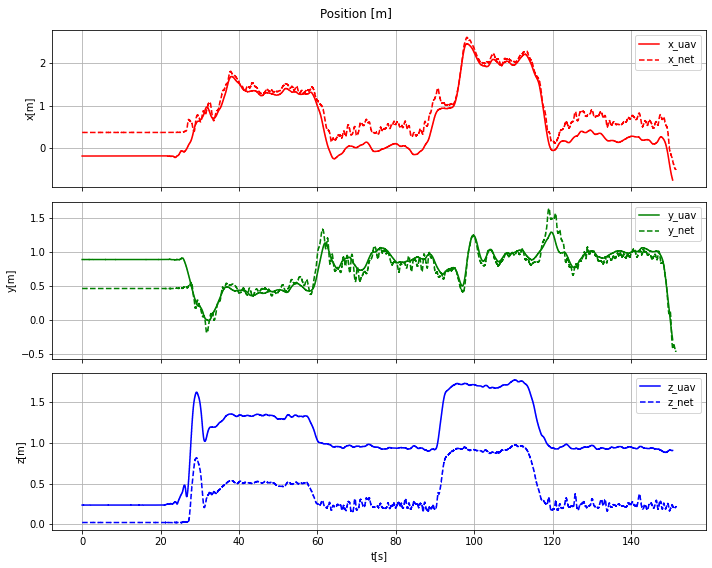

In [21]:
plot_positions(t1, x1, y1, z1, t2, x2, y2, z2)

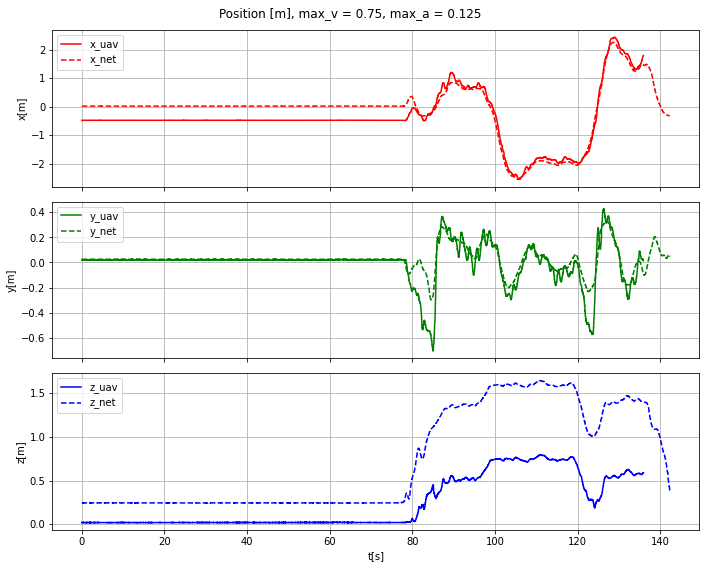

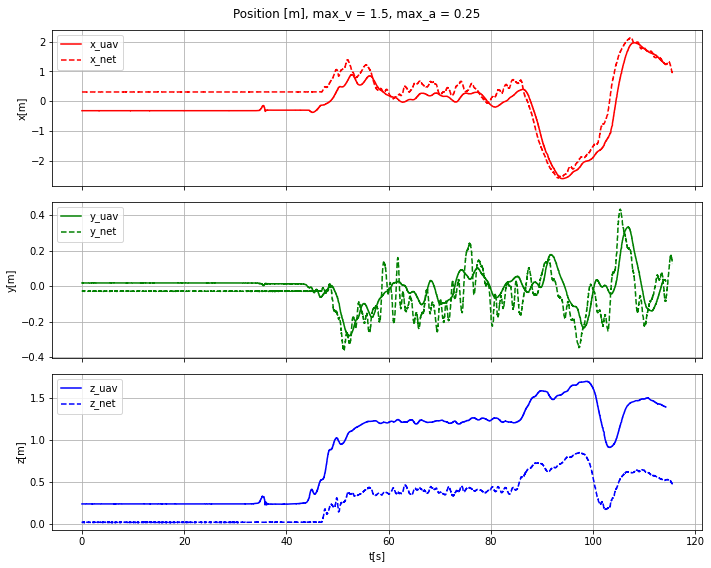

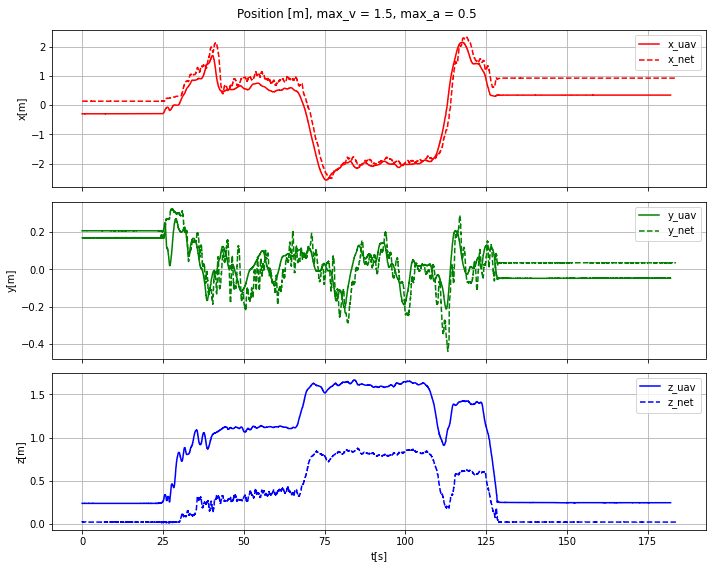

In [88]:
# UAV Slow
# uav_slow = crop_df_time(uav_slow, 120, 135); net_slow = crop_df_time(net_slow, 120, 135)
ts0,xs0,ys0,zs0 = extract_positions(uav_slow)
ts1,xs1,ys1,zs1 = extract_positions(net_slow)
plot_positions(ts0, xs0, ys0, zs0, ts1, xs1, ys1, zs1, title=(0.75, 0.125))

# UAV middle 
#uav_mid = crop_df_time(uav_mid, 120, 1); net_mid = crop_df_time()
tm0,xm0,ym0,zm0 = extract_positions(uav_mid)
tm1,xm1,ym1,zm1 = extract_positions(net_mid)
plot_positions(tm0, xm0, ym0, zm0, tm1, xm1, ym1, zm1, title=(1.5, 0.25))

# UAV fast
#uav_fast = crop_df_time(); net_fast= crop_df_time()
tf0,xf0,yf0,zf0 = extract_positions(uav_fast)
tf1,xf1,yf1,zf1 = extract_positions(net_fast)
plot_positions(tf0, xf0, yf0, zf0, tf1, xf1, yf1, zf1, title=(1.5, 0.5))




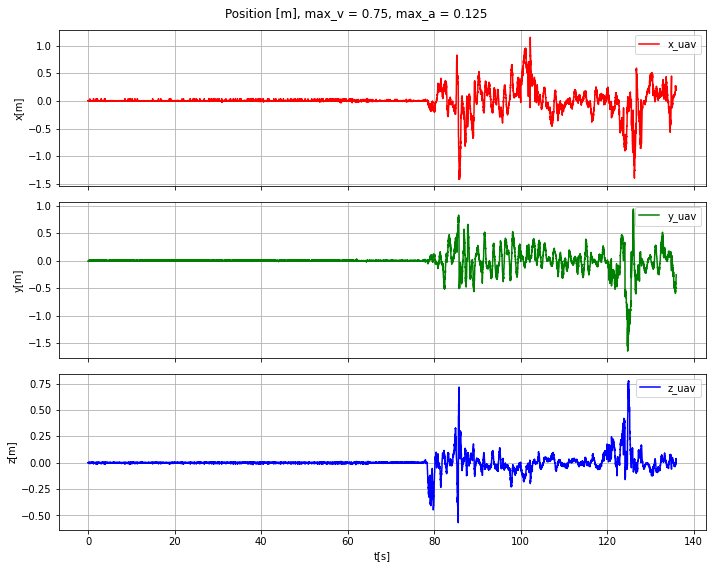

In [94]:
ts0,vxs0,vys0,vzs0 = extract_velocities(uav_slow)
ts1,vxs1,vys1,vzs1 = extract_velocities(net_slow)
plot_positions(ts0, vxs0, vys0, vzs0, ts1, vxs1, vys1, vzs1, title=(0.75, 0.125))

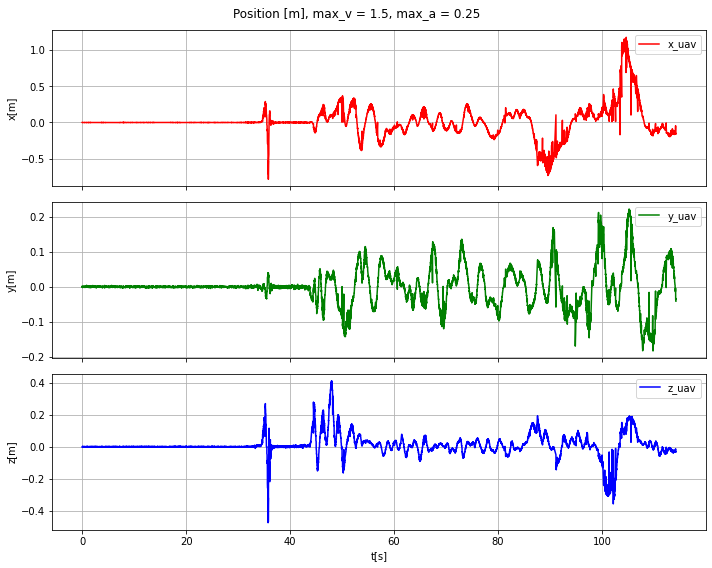

In [92]:
tm0,xm0,ym0,zm0 = extract_velocities(uav_mid)
tm1,xm1,ym1,zm1 = extract_velocities(net_mid)
plot_positions(tm0, xm0, ym0, zm0, tm1, xm1, ym1, zm1, title=(1.5, 0.25))

Text(0.5, 0.98, 'Positions [m]')

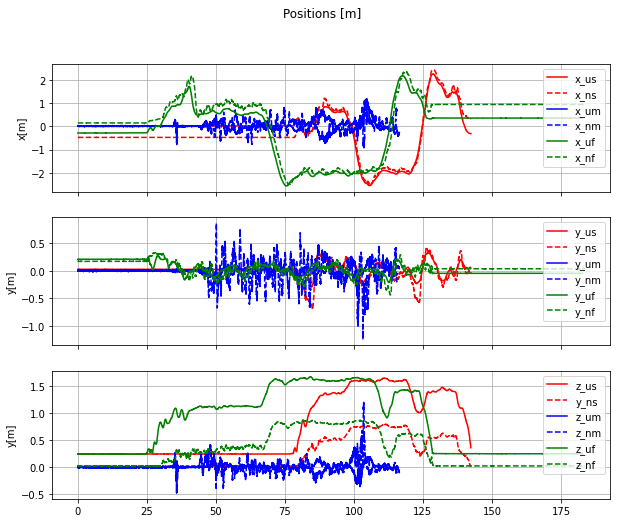

In [93]:
# Create a 2x1 subplot grid
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot object 1 positions
ax1.plot(ts0, xs0, label='x_us', color='red')
ax1.plot(ts1, xs1, label='x_ns', color='red', linestyle='--')
# Medium 
ax1.plot(tm0, xm0, label='x_um', color='blue')
ax1.plot(tm1, xm1, label='x_nm', color='blue', linestyle='--')
# Fast
ax1.plot(tf0, xf0, label='x_uf', color='green')
ax1.plot(tf1, xf1, label='x_nf', color='green', linestyle='--')


ax1.set_ylabel('x[m]')
ax1.grid()
ax1.legend()

# Plot object 2 positions
ax2.plot(ts0, ys0, label='y_us', color='red')
ax2.plot(ts1, ys1, label='y_ns', color='red', linestyle='--')
# Medium 
ax2.plot(tm0, ym0, label='y_um', color='blue')
ax2.plot(tm1, ym1, label='y_nm', color='blue', linestyle='--')
# Fast
ax2.plot(tf0, yf0, label='y_uf', color='green')
ax2.plot(tf1, yf1, label='y_nf', color='green', linestyle='--')
ax2.set_ylabel('y[m]')
ax2.grid()
ax2.legend()
    
# Plot object 2 positions
ax3.plot(ts0, zs0, label='z_us', color='red')
ax3.plot(ts1, zs1, label='y_ns', color='red', linestyle='--')
# Medium 
ax3.plot(tm0, zm0, label='z_um', color='blue')
ax3.plot(tm1, zm1, label='z_nm', color='blue', linestyle='--')
# Fast
ax3.plot(tf0, zf0, label='z_uf', color='green')
ax3.plot(tf1, zf1, label='z_nf', color='green', linestyle='--')
ax3.set_ylabel('y[m]')
ax3.grid()
ax3.legend()

plt.suptitle('Positions [m]')

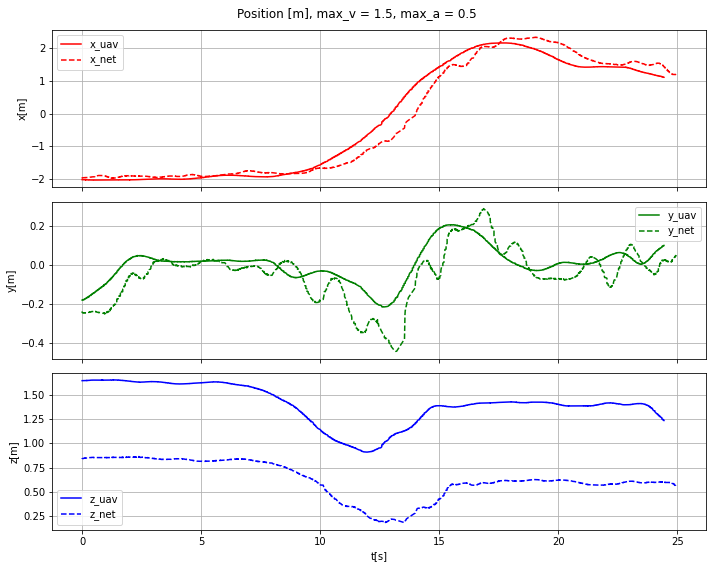

In [78]:
uav_slow = crop_df_time(uav_slow, 120, 135); net_slow = crop_df_time(net_slow, 120, 135)
ts0,xs0,ys0,zs0 = extract_positions(uav_slow)
ts1,xs1,ys1,zs1 = extract_positions(net_slow)

uav_mid = crop_df_time(uav_mid, 95, 115); net_mid = crop_df_time(net_mid, 95, 115)
tm0,xm0,ym0,zm0 = extract_positions(uav_mid)
tm1,xm1,ym1,zm1 = extract_positions(net_mid)

uav_fast = crop_df_time(uav_fast, 100, 125); net_fast= crop_df_time(net_fast, 100, 125)
tf0,xf0,yf0,zf0 = extract_positions(uav_fast)
tf1,xf1,yf1,zf1 = extract_positions(net_fast)

Text(0.5, 0.98, 'Positions [m]')

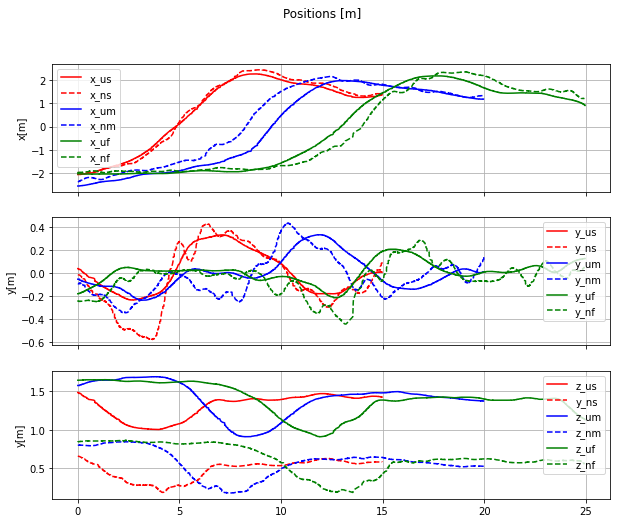

In [79]:
# Create a 2x1 subplot grid
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot object 1 positions
ax1.plot(ts0, xs0, label='x_us', color='red')
ax1.plot(ts1, xs1, label='x_ns', color='red', linestyle='--')
# Medium 
ax1.plot(tm0, xm0, label='x_um', color='blue')
ax1.plot(tm1, xm1, label='x_nm', color='blue', linestyle='--')
# Fast
ax1.plot(tf0, xf0, label='x_uf', color='green')
ax1.plot(tf1, xf1, label='x_nf', color='green', linestyle='--')


ax1.set_ylabel('x[m]')
ax1.grid()
ax1.legend()

# Plot object 2 positions
ax2.plot(ts0, ys0, label='y_us', color='red')
ax2.plot(ts1, ys1, label='y_ns', color='red', linestyle='--')
# Medium 
ax2.plot(tm0, ym0, label='y_um', color='blue')
ax2.plot(tm1, ym1, label='y_nm', color='blue', linestyle='--')
# Fast
ax2.plot(tf0, yf0, label='y_uf', color='green')
ax2.plot(tf1, yf1, label='y_nf', color='green', linestyle='--')
ax2.set_ylabel('y[m]')
ax2.grid()
ax2.legend()
    
# Plot object 2 positions
ax3.plot(ts0, zs0, label='z_us', color='red')
ax3.plot(ts1, zs1, label='y_ns', color='red', linestyle='--')
# Medium 
ax3.plot(tm0, zm0, label='z_um', color='blue')
ax3.plot(tm1, zm1, label='z_nm', color='blue', linestyle='--')
# Fast
ax3.plot(tf0, zf0, label='z_uf', color='green')
ax3.plot(tf1, zf1, label='z_nf', color='green', linestyle='--')
ax3.set_ylabel('y[m]')
ax3.grid()
ax3.legend()

plt.suptitle('Positions [m]')

## 3D trajectory plot of the UAV and the Net

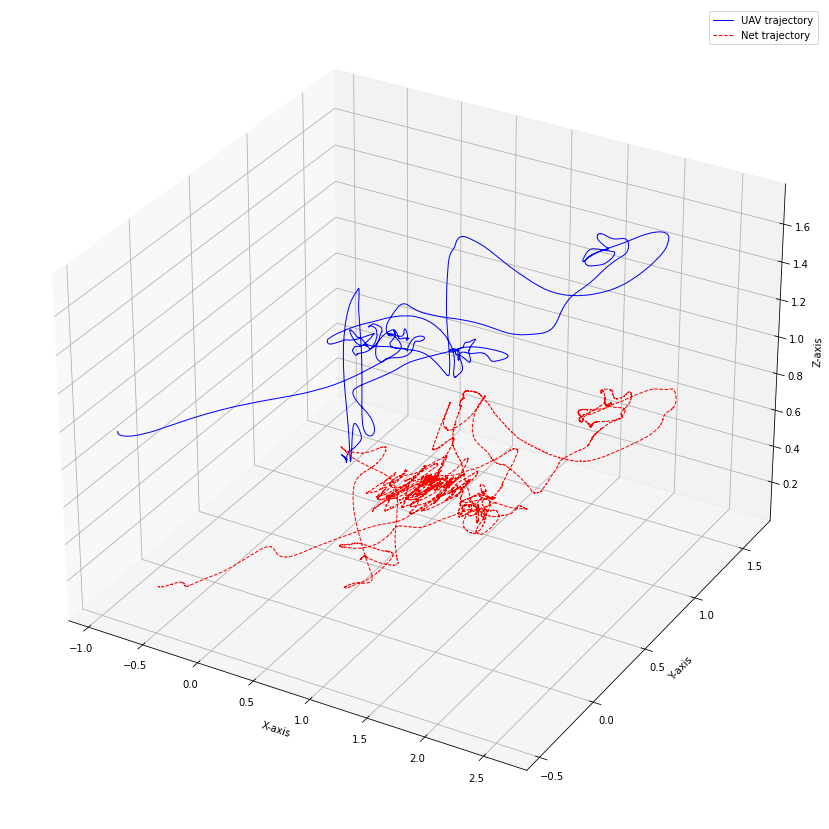

In [22]:
plot_trajectories(x1, y1, z1, x2, y2, z2)

In [47]:
poses = det_poses['poses']
def extract_poses(det_poses): 
    poses = det_poses['poses']
    for i in poses: 
        i = i.split(" ")
        x = 
        print(i)
extract_poses(det_poses)

['[pose:', '\n', '', 'x:', '0.8975622653961182\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8975622653961182\n', '', 'y:', '-0.5240288972854614\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8975622653961182\n', '', 'y:', '-0.5240288972854614\n', '', 'z:', '1.564000129699707\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '1.531000018119812\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '0.8786239624023438\n', '', 'y:', '-0.5129720568656921\n', '', 'z:', '1.531000018

['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '2.502000093460083\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.5779728889465332\n', '', 'y:', '-0.8383122086524963\n', '', 'z:', '2.502000093460083\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '0.0\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '-0.8852202296257019\n', '', 'z:', '0.0\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '-0.8852202296257019\n', '', 'z:', '2.642000198364258\nid:', '0]']
['[pose:', '\n', '', 'x:', '-1.6662687063217163\n', '', 'y:', '0.0\n',

In [108]:
#t, x, y, z = get_relative_position(uav_pose_new, net_pose_new)
#plot_relative_position(t, x, y, z)
#uav_pose_new, net_pose_new = upsample_dataframes(uav_pose, net_pose)

# TODO: 
- [x] Plot UAV and the NET position 
- [x] Plot relative position
- [x] Plot net orientation
- [ ] Increase fonts and legends
- [x] Plot Bezier for starters and check pool 
- [ ] Plot UAV and the NET position for the multiple times 
- [ ] Crop method based on the time
- [ ] Plot relative position between UAV - NET (done) and Object (not done)  

## Findings: 
- [x] When optitrack loses markers, we lose measurements (more optitrack markers)
- [ ] Optitrack markers on a can (to record even relative position between net and the object) 
